# EVN

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# 문장 긍정(1), 부정(0) 분류 프로젝트

## 데이터

In [4]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [1, 0]  # 긍정(1), 부정(0)

# 정답 dic
id_to_label = {0: '부정', 1: '긍정'}

## Vocabulary

In [5]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())
words

['나는', '오늘', '기분이', '좋아', '나는', '오늘', '우울해']

In [6]:
# 중복 단어 제거
words = list(dict.fromkeys(words))
words

['나는', '오늘', '기분이', '좋아', '우울해']

In [7]:
# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5}

In [8]:
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}
id_to_word

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'}

## 모델 학습용 데이터 생성

In [9]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])
train_inputs

[[2, 3, 4, 5], [2, 3, 6]]

In [10]:
# train label은 labels를 그래도 사용
train_labels = labels
train_labels

[1, 0]

In [11]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:
    row += [0] * (4 - len(row))
train_inputs

[[2, 3, 4, 5], [2, 3, 6, 0]]

In [12]:
# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_inputs

array([[2, 3, 4, 5],
       [2, 3, 6, 0]])

In [13]:
# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)
train_labels

array([1, 0])

## 모델링

In [49]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 8)
hidden = embedding(train_inputs)
train_inputs.shape,hidden

((2, 4), <tf.Tensor: shape=(2, 4, 8), dtype=float32, numpy=
 array([[[ 0.0295745 ,  0.02581297, -0.0183221 , -0.00649625,
           0.02075974, -0.02960384, -0.04806751, -0.00976444],
         [-0.02484336, -0.01645992, -0.02648627,  0.04994151,
           0.00547023,  0.00776557,  0.02968638, -0.01105888],
         [ 0.04570374, -0.03362765, -0.00290646,  0.04314513,
          -0.00804549,  0.02582458,  0.03250761,  0.04754379],
         [ 0.00306601,  0.01401324, -0.03258304, -0.04239291,
           0.04998927, -0.0224789 , -0.02044283, -0.00468051]],
 
        [[ 0.0295745 ,  0.02581297, -0.0183221 , -0.00649625,
           0.02075974, -0.02960384, -0.04806751, -0.00976444],
         [-0.02484336, -0.01645992, -0.02648627,  0.04994151,
           0.00547023,  0.00776557,  0.02968638, -0.01105888],
         [-0.03156056,  0.02061215, -0.01543728,  0.01412294,
          -0.04629259, -0.01025498, -0.00780542, -0.02165675],
         [ 0.04564948, -0.01426696, -0.01759647,  0.01697757,


In [15]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool = pool(hidden)
hidden_pool

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 0.03125665,  0.04297395,  0.04682766, -0.00156049,  0.04694157,
         0.02360536,  0.02801709,  0.04375419],
       [ 0.02204413,  0.03243068,  0.04682766,  0.02439186,  0.00428741,
         0.03733661,  0.04195901,  0.04375419]], dtype=float32)>

In [17]:
# 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
outputs = linear(hidden_pool)
outputs

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5087283 , 0.4912716 ],
       [0.52492255, 0.47507748]], dtype=float32)>

In [51]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    동작만 하는 간단한 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    
    # 차원을 늘려준다(벡터 차원 수에 맞게끔)
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)

    # 벡터의 최댓값을 기준으로 차원을 줄여준다.
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool = pool(hidden)

    linear = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)
    outputs = linear(hidden_pool)
    ########################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

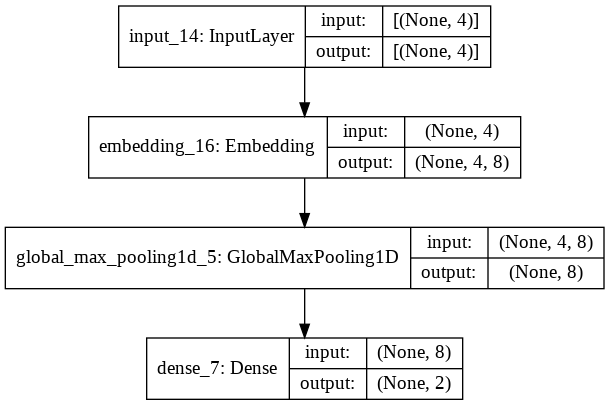

In [52]:
# 모델 생성
model = build_model(len(word_to_id), 8, 4, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## 학습

In [53]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
train_inputs, train_labels

(array([[2, 3, 4, 5],
        [2, 3, 6, 0]]), array([1, 0]))

In [66]:
# 모델 학습
history = model.fit(train_inputs, train_labels, epochs=20, batch_size=16)

Epoch 1/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 0.6354 - accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 5ms/step - loss: 0.6324 - accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 5ms/step - loss: 0.6293 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 5ms/step - loss: 0.6230 - accuracy: 1.0000
Epoch 11/20
1/1 [======================

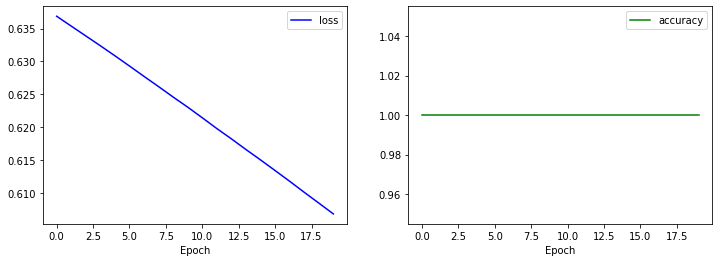

In [67]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 평가

In [68]:
# 모델 평가
model.evaluate(train_inputs, train_labels)

1/1 [==============================] - 0s 15ms/step - loss: 0.6051 - accuracy: 1.0000


[0.605107307434082, 1.0]

## 예측

In [69]:
# 추론할 입력
string = '나는 기분이 우울해'

In [70]:
# 입력을 숫자로 변경
infer_input = [word_to_id[word] for word in string.split()]
infer_input

[2, 4, 6]

In [71]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
infer_input += [0] * (4 - len(infer_input))
infer_input

[2, 4, 6, 0]

In [73]:
# numpy array 변환 (batch size 1 추가)
infer_inputs = np.array([infer_input])
infer_inputs

array([[2, 4, 6, 0]])

In [74]:
# 긍정/부정 추론
y_preds = model.predict(infer_inputs)
y_preds

array([[0.50587946, 0.49412048]], dtype=float32)

In [75]:
# 확률의 max 값을 추론 값으로 결정
y_pred_class = np.argmax(y_preds, axis=1)
y_pred_class

array([0])

In [76]:
# 각 예측 값에 대한 label string
for val in y_pred_class:
    print(val, ':', id_to_label[val])

0 : 부정
